# Algorithmic_Trading_Machine_Learning_Quant_Strategies

All Packages Needed:
- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
import pandas as pd 
import numpy as np 
import datetime as dt 
import yfinance as yf 
import pandas_ta 
import warnings
warnings.filterwarnings('ignore')

# 1. Download/Load SP500 stock prices data.

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')  # some tickers with '.' could cause issues later
 
symbols_list = sp500['Symbol'].unique().tolist() # not suvivorship-bias free

end_date = '2024-01-03'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date)
df

[*********************100%%**********************]  503 of 503 completed


16 Failed downloads:
['INVH', 'CSX', 'GPN', 'DE', 'CHRW', 'NRG', 'ABT', 'DG', 'WTW', 'VLO', 'BLDR', 'TECH', 'FITB', 'ETR', 'TTWO', 'ODFL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-01-05 00:00:00 -> 2024-01-03)')


Adj Close                                                     \
                     A        AAL        AAPL        ABBV        ABNB ABT   
Date                                                                        
2016-01-05   38.003223  38.722759   23.376621   40.608200         NaN NaN   
2016-01-06   38.171917  39.401268   22.919140   40.615273         NaN NaN   
2016-01-07   36.550568  38.655869   21.951845   40.494949         NaN NaN   
2016-01-08   36.166321  38.579414   22.067928   39.390732         NaN NaN   
2016-01-11   35.557148  39.257915   22.425257   38.137871         NaN NaN   
...                ...        ...         ...         ...         ...  ..   
2023-12-26  139.573929  14.110000  193.050003  154.619995  138.720001 NaN   
2023-12-27  139.583923  13.990000  193.149994  154.880005  136.550003 NaN   
2023-12-28  139.534012  13.980000  193.580002  154.750000  137.000000 NaN   
2023-12-29  139.029999  13.740000  192.529999  154.970001  136.139999 NaN   
2024-01-02  138.750000  13.440000  185.639999  159.820007  134.479996 NaN   

                                                           ...   Volume  \
                 ACGL         ACN        ADBE         ADI  ...     WYNN   
Date                                                       ...            
2016-01-05  23.033333   90.069466   92.339996   45.841988  ...  4286100   
2016-01-06  23.070000   89.893494   91.019997   43.890903  ...  3316100   
2016-01-07  23.046667   87.253700   89.110001   42.771145  ...  5525600   
2016-01-08  22.806667   86.408981   87.849998   42.397911  ...  5740000   
2016-01-11  22.760000   87.315315   89.379997   43.407372  ...  4612400   
...               ...         ...         ...         ...  ...      ...   
2023-12-26  73.510002  353.429993  598.260010  198.869995  ...  1150000   
2023-12-27  73.540001  353.820007  596.080017  199.350006  ...  1142200   
2023-12-28  74.059998  351.589996  595.520020  200.240005  ...  1233000   
2023-12-29  74.269997  350.910004  596.599976  198.559998  ...  1144800   
2024-01-02  75.550003  346.920013  580.070007  193.580002  ...  3013600   

                                                                             \
                XEL       XOM     XRAY      XYL       YUM      ZBH     ZBRA   
Date                                                                          
2016-01-05  2141200  11993500  1611200  1075400   5273420  2294737   611300   
2016-01-06  5191900  18826900  1179700  1866000   5049330  2751233   881900   
2016-01-07  5212200  21263800  1140400  1555400  11005453  1829589  1210600   
2016-01-08  3005400  19033600  1233700  1471500   5996184  1670969  1034700   
2016-01-11  3885400  21353000  1867600   852900   5891859  1626164  1034700   
...             ...       ...      ...      ...       ...      ...      ...   
2023-12-26  2147500  16835100  1335200   440300    627500  1870700   220000   
2023-12-27  2865900  14558800  1202800  1007700   1050400  1058600   275700   
2023-12-28  2421900  16329300  1152300   709100    882500   662200   193900   
2023-12-29  2813300  17741400  1330600   698900   1196800   849600   251300   
2024-01-02  4627600  23483000  1684400  1089400   1485300  1087400   452900   

                              
               ZION      ZTS  
Date                          
2016-01-05  2653600  3116700  
2016-01-06  4164200  4670500  
2016-01-07  4234000  4324400  
2016-01-08  3401600  4946100  
2016-01-11  4627200  4306900  
...             ...      ...  
2023-12-26  1131600   814600  
2023-12-27  1345100   766400  
2023-12-28  1125900   880100  
2023-12-29  1420600  1007200  
2024-01-02  2256700  1642300  

[2012 rows x 3018 columns]

the above object has a multi-index column: e.g. Adj Close : [A,AAL,AAPL,...], Volume: [...]
also there's a ton of columns & this is inefficient. to fix this:

In [3]:
df = df.stack()
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-05 A      38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL    38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL   23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV   40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL   23.033333   23.033333   23.123333   22.760000   22.893333   
...                     ...         ...         ...         ...         ...   
2024-01-02 YUM   129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH   121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA  267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION   44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS   196.570007  196.570007  197.949997  195.050003  195.789993   

                      Volume  
Date                          
2016-01-05 A       2587200.0  
           AAL    10514200.0  
           AAPL  223164000.0  
           ABBV    7179600.0  
           ACGL    1497600.0  
...                      ...  
2024-01-02 YUM     1485300.0  
           ZBH     1087400.0  
           ZBRA     452900.0  
           ZION    2256700.0  
           ZTS     1642300.0  

[962607 rows x 6 columns]

In [4]:
df.index.names = ['date','ticker']
df

Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        Volume  
date       ticker               
2016-01-05 A         2587200.0  
           AAL      10514200.0  
           AAPL    223164000.0  
           ABBV      7179600.0  
           ACGL      1497600.0  
...                        ...  
2024-01-02 YUM       1485300.0  
           ZBH       1087400.0  
           ZBRA       452900.0  
           ZION      2256700.0  
           ZTS       1642300.0  

[962607 rows x 6 columns]

In [5]:
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  
date       ticker               
2016-01-05 A         2587200.0  
           AAL      10514200.0  
           AAPL    223164000.0  
           ABBV      7179600.0  
           ACGL      1497600.0  
...                        ...  
2024-01-02 YUM       1485300.0  
           ZBH       1087400.0  
           ZBRA       452900.0  
           ZION      2256700.0  
           ZTS       1642300.0  

[962607 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

Garman-Klass Volatility = ((ln(High) - ln(Low))^2)/2 - (2ln(2) - 1)(ln(Adj Close) - ln(Open))^2

In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol  
date       ticker                                 
2016-01-05 A         2587200.0         -0.001742  
           AAL      10514200.0         -0.000747  
           AAPL    223164000.0         -0.005303  
           ABBV      7179600.0         -0.048731  
           ACGL      1497600.0          0.000111  
...                        ...               ...  
2024-01-02 YUM       1485300.0          0.000080  
           ZBH       1087400.0          0.000092  
           ZBRA       452900.0          0.000197  
           ZION      2256700.0          0.000537  
           ZTS       1642300.0          0.000103  

[962607 rows x 7 columns]

RSI

In [7]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20)) #level 0 is date, and level 1 in the index is the ticker
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi  
date       ticker                                            
2016-01-05 A         2587200.0         -0.001742        NaN  
           AAL      10514200.0         -0.000747        NaN  
           AAPL    223164000.0         -0.005303        NaN  
           ABBV      7179600.0         -0.048731        NaN  
           ACGL      1497600.0          0.000111        NaN  
...                        ...               ...        ...  
2024-01-02 YUM       1485300.0          0.000080  54.181055  
           ZBH       1087400.0          0.000092  67.367561  
           ZBRA       452900.0          0.000197  63.392193  
           ZION      2256700.0          0.000537  63.435002  
           ZTS       1642300.0          0.000103  65.276723  

[962607 rows x 8 columns]

<Axes: xlabel='date'>

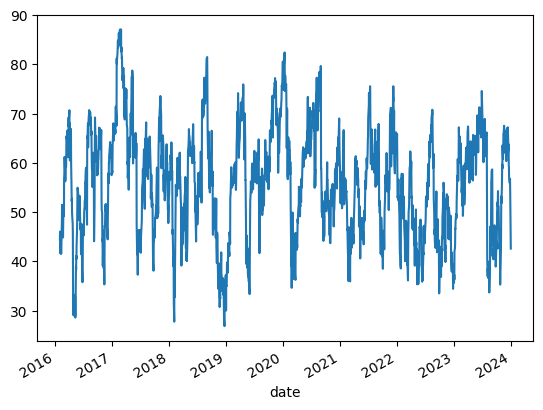

In [8]:
df.xs('AAPL', level=1)['rsi'].plot()  # level 0 is date, and level 1 in the index is the ticker

Bollinger Bands

- Now for each indicator, we'd like to normalize and scale

In [9]:
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
date,,,,,
2016-01-05,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN
2016-01-11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-12-26,188.431228,193.831501,199.231774,5.572131,0.427643
2023-12-27,188.789699,193.969001,199.148303,5.340340,0.420935
2023-12-28,189.441568,194.179501,198.917435,4.879953,0.436734


In [10]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.048731        NaN       NaN   
           ACGL      1497600.0          0.000111        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000103  65.276723  5.196835   

                     bb_mid   bb_high  
date       ticker                      
2016-01-05 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2024-01-02 YUM     4.825425  4.825425  
           ZBH     4.753768  4.753768  
           ZBRA    5.422223  5.422223  
           ZION    3.620947  3.620947  
           ZTS     5.196835  5.196835  

[962607 rows x 11 columns]

ATR

In [11]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
              low=stock_data['low'],
              close=stock_data['close'],
              length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df


adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.048731        NaN       NaN   
           ACGL      1497600.0          0.000111        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000103  65.276723  5.196835   

                     bb_mid   bb_high       atr  
date       ticker                                
2016-01-05 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2024-01-02 YUM     4.825425  4.825425 -0.069710  
           ZBH     4.753768  4.753768 -1.051946  
           ZBRA    5.422223  5.422223 -0.135093  
           ZION    3.620947  3.620947  0.186439  
           ZTS     5.196835  5.196835  0.399498  

[962607 rows x 12 columns]

MACD

In [12]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.048731        NaN       NaN   
           ACGL      1497600.0          0.000111        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000103  65.276723  5.196835   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-01-05 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-01-02 YUM     4.825425  4.825425 -0.069710  0.669913  
           ZBH     4.753768  4.753768 -1.051946  0.948196  
           ZBRA    5.422223  5.422223 -0.135093  1.473233  
           ZION    3.620947  3.620947  0.186439  2.009179  
           ZTS     5.196835  5.196835  0.399498  2.052080  

[962607 rows x 13 columns]

- Dollar Volume

In [13]:
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003223   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.608200   57.369999   58.250000   56.820000   57.990002   
           ACGL     23.033333   23.033333   23.123333   22.760000   22.893333   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.570007  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.048731        NaN       NaN   
           ACGL      1497600.0          0.000111        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000103  65.276723  5.196835   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-05 A            NaN       NaN       NaN       NaN      98.321940  
           AAL          NaN       NaN       NaN       NaN     407.138835  
           AAPL         NaN       NaN       NaN       NaN    5216.820304  
           ABBV         NaN       NaN       NaN       NaN     291.550633  
           ACGL         NaN       NaN       NaN       NaN      34.494719  
...                     ...       ...       ...       ...            ...  
2024-01-02 YUM     4.825425  4.825425 -0.069710  0.669913     191.648257  
           ZBH     4.753768  4.753768 -1.051946  0.948196     131.999485  
           ZBRA    5.422223  5.422223 -0.135093  1.473233     121.368147  
           ZION    3.620947  3.620947  0.186439  2.009179      99.610737  
           ZTS     5.196835  5.196835  0.399498  2.052080     322.826923  

[962607 rows x 14 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end fequency.

In [15]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2016-01-31 A           93.533659
           AAL        475.727904
           AAPL      5953.037505
           ABBV       462.464142
           ACGL        38.975375
...                          ...
2024-01-31 ABNB       468.689681
           CEG        157.062700
           GEHC       152.976753
           KVUE       759.613423
           VLTO        91.520188

[46422 rows x 1 columns]

In [16]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open',
                                                          'high','low','close']]
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [21]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis=1)).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A           91.918053   35.004189         -0.001914  48.218627   
           AAL        338.977804   39.288368         -0.000319  56.939338   
           AAPL      3548.073701   22.125887         -0.003013  49.176721   
           ABBV       357.006461   39.060577         -0.049102  48.001227   
           ACGL        31.542992   22.646667          0.000102  50.122259   
...                          ...         ...               ...        ...   
2024-01-31 ABNB       468.689681  134.479996          0.000141  49.250925   
           CEG        157.062700  115.250000          0.000151  47.015480   
           GEHC       152.976753   76.370003          0.000245  60.705790   
           KVUE       759.613423   21.570000          0.000190  60.839600   
           VLTO        91.520188   81.019997          0.000320  59.162350   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.522492  3.522492  3.522492 -0.931873 -0.230851  
           AAL     3.547833  3.547833  3.547833  0.977102  0.525166  
           AAPL    3.106253  3.106253  3.106253 -1.019133 -0.322382  
           ABBV    3.638599  3.638599  3.638599 -0.475529 -0.301063  
           ACGL    3.135094  3.135094  3.135094 -0.623590 -0.093646  
...                     ...       ...       ...       ...       ...  
2024-01-31 ABNB    4.887059  4.887059  4.887059 -1.059294  0.375025  
           CEG     4.721016  4.721016  4.721016  0.327186 -0.854191  
           GEHC    4.214347  4.214347  4.214347 -1.057706  0.922290  
           KVUE    3.041202  3.041202  3.041202 -1.401968  2.073787  
           VLTO    4.312247  4.312247  4.312247 -0.920476  1.193189  

[45933 rows x 9 columns]